# Visualize drought impacts in hive plots

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import interpolate
import matplotlib.gridspec as grid_spec

Classify realizations into their characteristics (variability, persistence, drought occurence)

In [2]:
# Load in all drought counts for all realizations
droughts_df = pd.read_csv('../rival_framings_demand/drought_counts_all_realizations.csv', index_col=0)
droughts_df.index = np.arange(1, len(droughts_df) + 1)

# Load in all drought impacts for all realizations using 100 years to set threshold
# Classification column uses drought occurences (drought_impacts_all_users_summary.ipynb)
drought_impacts_df = pd.read_csv('drought_impacts_all_realizations.csv', index_col=0)
drought_impacts_df.index = np.arange(1, len(drought_impacts_df) + 1)

#Identify realizations have <=21 years of drought 
drought_cat_realizations = drought_impacts_df[drought_impacts_df['Classification'] == 'History'].index.values

In [3]:
# Load in sample information to classify realizations on variability and persistence
parameter_values = pd.read_csv('./data/LHsamples_wider_100_AnnQonly.txt', sep='\t', lineterminator='\r', header=0)
variability_cat_samples = parameter_values[parameter_values['sigma_wet'] >= 0.69].index.values
persistence_cat_samples = parameter_values[parameter_values['p_drydry'] <= 0.07].index.values
variability_cat_realizations = np.concatenate([np.arange(x*10+1, x*10+10+1) for x in variability_cat_samples], 
                                              axis=0 )
persistence_cat_realizations = np.concatenate([np.arange(x*10+1, x*10+10+1) for x in persistence_cat_samples], 
                                              axis=0 )

Classify outcomes into groups

In [4]:
no_users_thresh = 50
magnitude_thresh = 10
delivery_thresh = 2

# create a list of our conditions
group_conditions = [
    # Criteria for group 1
    (drought_impacts_df['Outflow_percentile_violation'] <= delivery_thresh) &
    (drought_impacts_df['%_users'] >= no_users_thresh) & 
    (drought_impacts_df['Magnitude'] >= magnitude_thresh), 
    # Criteria for group 2
    (drought_impacts_df['Outflow_percentile_violation'] <= delivery_thresh) &
    (drought_impacts_df['%_users'] >= no_users_thresh) & 
    (drought_impacts_df['Magnitude'] < magnitude_thresh), 
    # Criteria for group 3
    (drought_impacts_df['Outflow_percentile_violation'] <= delivery_thresh) &
    (drought_impacts_df['%_users'] < no_users_thresh) & 
    (drought_impacts_df['Magnitude'] >= magnitude_thresh),     
    # Criteria for group 4
    (drought_impacts_df['Outflow_percentile_violation'] <= delivery_thresh) &
    (drought_impacts_df['%_users'] < no_users_thresh) & 
    (drought_impacts_df['Magnitude'] < magnitude_thresh), 
    # Criteria for group 5
    (drought_impacts_df['Outflow_percentile_violation'] > delivery_thresh) &
    (drought_impacts_df['%_users'] >= no_users_thresh) & 
    (drought_impacts_df['Magnitude'] >= magnitude_thresh), 
    # Criteria for group 6
    (drought_impacts_df['Outflow_percentile_violation'] > delivery_thresh) &
    (drought_impacts_df['%_users'] >= no_users_thresh) & 
    (drought_impacts_df['Magnitude'] < magnitude_thresh), 
    # Criteria for group 7
    (drought_impacts_df['Outflow_percentile_violation'] > delivery_thresh) &
    (drought_impacts_df['%_users'] < no_users_thresh) & 
    (drought_impacts_df['Magnitude'] >= magnitude_thresh),     
    # Criteria for group 8
    (drought_impacts_df['Outflow_percentile_violation'] > delivery_thresh) &
    (drought_impacts_df['%_users'] < no_users_thresh) & 
    (drought_impacts_df['Magnitude'] < magnitude_thresh)
    ] 

# create a list of the values we want to assign for each condition
group_values = list(np.arange(1,9))

# create a new column and use np.select to assign values to it using our lists as arguments
drought_impacts_df['Group'] = np.select(group_conditions, group_values)

In [5]:
#Repeat classification, but into three category pairs

classifications = ['Variable&Persistent', 'Persistent&Drought', 'Drought&Variable']

# create a list of our conditions
category_conditions = [
    # Criteria for category 1
    (drought_impacts_df.index.isin(variability_cat_realizations)) &
    (drought_impacts_df.index.isin(persistence_cat_realizations)) , 
    # Criteria for category 2
    (drought_impacts_df.index.isin(persistence_cat_realizations)) &
    (drought_impacts_df.index.isin(drought_cat_realizations)), 
    # Criteria for category 3
    (drought_impacts_df.index.isin(drought_cat_realizations)) &
    (drought_impacts_df.index.isin(variability_cat_realizations)) 
    ] 

# create a new column and use np.select to assign values to it using our lists as arguments
drought_impacts_df['Category'] = np.select(category_conditions, classifications)

In [6]:
group_ratios = np.zeros((3,8))

# Loop through all classifications and all groups and calculate ratios
for i, c in enumerate(classifications):
    total_reals = len(drought_impacts_df[drought_impacts_df['Category']==c])
    for j, value in enumerate(group_values):
        group_ratios[i,j] = np.around(len(drought_impacts_df[(drought_impacts_df['Category']==c) & 
                                                        (drought_impacts_df['Group']==value)])/total_reals*100, 
                                 decimals=1)

In [7]:
# Create hive plot dataframe
# Calculate ratios of each group in each realization classification
df = pd.DataFrame(group_ratios, columns = [f'Group {x}' for x in group_values])

cum_sum_df = df.cumsum(axis=1)
cum_sum_df.insert(0, 'Initial_values', np.zeros(3))
cum_sum_df['angle_start'] = [0, 120, 240]
cum_sum_df['angle_end'] = [120, 240, 360]

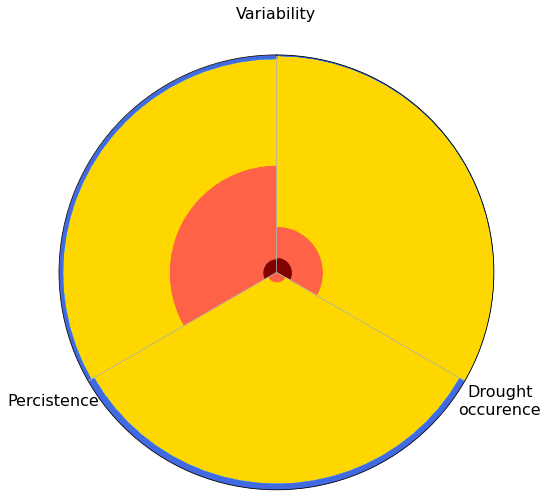

In [8]:
colors = ['maroon', 'tomato', 'orange', 'gold',
         'yellowgreen', 'forestgreen', 'lightskyblue', 'royalblue']

# Initialise the spider plot
plt.figure(figsize=(12,8))
ax = plt.subplot(polar=True)

# Extrapolate curves between angles
angles = [y/180*np.pi for x in [np.arange(x, x+125,5) for x in cum_sum_df.angle_start] for y in x]
segment_length = len(np.arange(0, 0+125,5))

# for every group extrapolate values and draw
for k in range(1, cum_sum_df.shape[1]-2):
    previous_values = sum([[cum_sum_df.iloc[i, k-1]]*segment_length for i in range(3)], [])
#     previous_values.append(previous_values[-1])
    values = sum([[cum_sum_df.iloc[i, k]]*segment_length for i in range(3)], [])
#     values.append(values[-1])
    
    # Plot data
    ax.fill_between(angles, previous_values, values, color=colors[k-1], label=f'Group {k}')

ax.set_thetagrids([0, 120, 240], ['Variability', 'Percistence', 'Drought\noccurence'], fontsize=16)
ax.xaxis.set_tick_params(pad=30)
ax.set_ylim([0,100])
ax.set_yticklabels([])
ax.set_rticks([])

#ax.legend(loc='upper left')


ax.set_theta_zero_location("N")


plt.show()

# Wrap everything in functions to explore all combinations of thresholds

In [4]:
#Static operations
classifications = ['Variable&Persistent', 'Persistent&Drought', 'Drought&Variable']
# create a list of our conditions
category_conditions = [
    # Criteria for category 1
    (drought_impacts_df.index.isin(variability_cat_realizations)) &
    (drought_impacts_df.index.isin(persistence_cat_realizations)) , 
    # Criteria for category 2
    (drought_impacts_df.index.isin(persistence_cat_realizations)) &
    (drought_impacts_df.index.isin(drought_cat_realizations)), 
    # Criteria for category 3
    (drought_impacts_df.index.isin(drought_cat_realizations)) &
    (drought_impacts_df.index.isin(variability_cat_realizations)) 
    ] 

# create a new column and use np.select to assign values to it using our lists as arguments
drought_impacts_df['Category'] = np.select(category_conditions, classifications)

#group colors
colors = ['maroon', 'tomato', 'orange', 'gold',
         'yellowgreen', 'forestgreen', 'lightskyblue', 'royalblue']

In [5]:
# Function that does all classification calculations
def group_classifications(drought_impacts_df, delivery_thresh, no_users_thresh, magnitude_thresh):
    # create a list of our conditions
    group_conditions = [
        # Criteria for group 1
        (drought_impacts_df['Outflow_percentile_violation'] <= delivery_thresh) &
        (drought_impacts_df['%_users'] >= no_users_thresh) & 
        (drought_impacts_df['Magnitude'] >= magnitude_thresh), 
        # Criteria for group 2
        (drought_impacts_df['Outflow_percentile_violation'] <= delivery_thresh) &
        (drought_impacts_df['%_users'] >= no_users_thresh) & 
        (drought_impacts_df['Magnitude'] < magnitude_thresh), 
        # Criteria for group 3
        (drought_impacts_df['Outflow_percentile_violation'] <= delivery_thresh) &
        (drought_impacts_df['%_users'] < no_users_thresh) & 
        (drought_impacts_df['Magnitude'] >= magnitude_thresh),     
        # Criteria for group 4
        (drought_impacts_df['Outflow_percentile_violation'] <= delivery_thresh) &
        (drought_impacts_df['%_users'] < no_users_thresh) & 
        (drought_impacts_df['Magnitude'] < magnitude_thresh), 
        # Criteria for group 5
        (drought_impacts_df['Outflow_percentile_violation'] > delivery_thresh) &
        (drought_impacts_df['%_users'] >= no_users_thresh) & 
        (drought_impacts_df['Magnitude'] >= magnitude_thresh), 
        # Criteria for group 6
        (drought_impacts_df['Outflow_percentile_violation'] > delivery_thresh) &
        (drought_impacts_df['%_users'] >= no_users_thresh) & 
        (drought_impacts_df['Magnitude'] < magnitude_thresh), 
        # Criteria for group 7
        (drought_impacts_df['Outflow_percentile_violation'] > delivery_thresh) &
        (drought_impacts_df['%_users'] < no_users_thresh) & 
        (drought_impacts_df['Magnitude'] >= magnitude_thresh),     
        # Criteria for group 8
        (drought_impacts_df['Outflow_percentile_violation'] > delivery_thresh) &
        (drought_impacts_df['%_users'] < no_users_thresh) & 
        (drought_impacts_df['Magnitude'] < magnitude_thresh)
        ] 

    # create a list of the values we want to assign for each condition
    group_values = list(np.arange(1,9))

    # create a new column and use np.select to assign values to it using our lists as arguments
    drought_impacts_df['Group'] = np.select(group_conditions, group_values)
    
    group_ratios = np.zeros((3,8))

    # Loop through all classifications and all groups and calculate ratios
    for i, c in enumerate(classifications):
        total_reals = len(drought_impacts_df[drought_impacts_df['Category']==c])
        for j, value in enumerate(group_values):
            group_ratios[i,j] = np.around(len(drought_impacts_df[(drought_impacts_df['Category']==c) & 
                                                            (drought_impacts_df['Group']==value)])/total_reals*100, 
                                     decimals=1)
    # Create hive plot dataframe
    # Calculate ratios of each group in each realization classification
    df = pd.DataFrame(group_ratios, columns = [f'Group {x}' for x in group_values])

    cum_sum_df = df.cumsum(axis=1)
    cum_sum_df.insert(0, 'Initial_values', np.zeros(3))
    cum_sum_df['angle_start'] = [0, 120, 240]
    cum_sum_df['angle_end'] = [120, 240, 360]
    return cum_sum_df


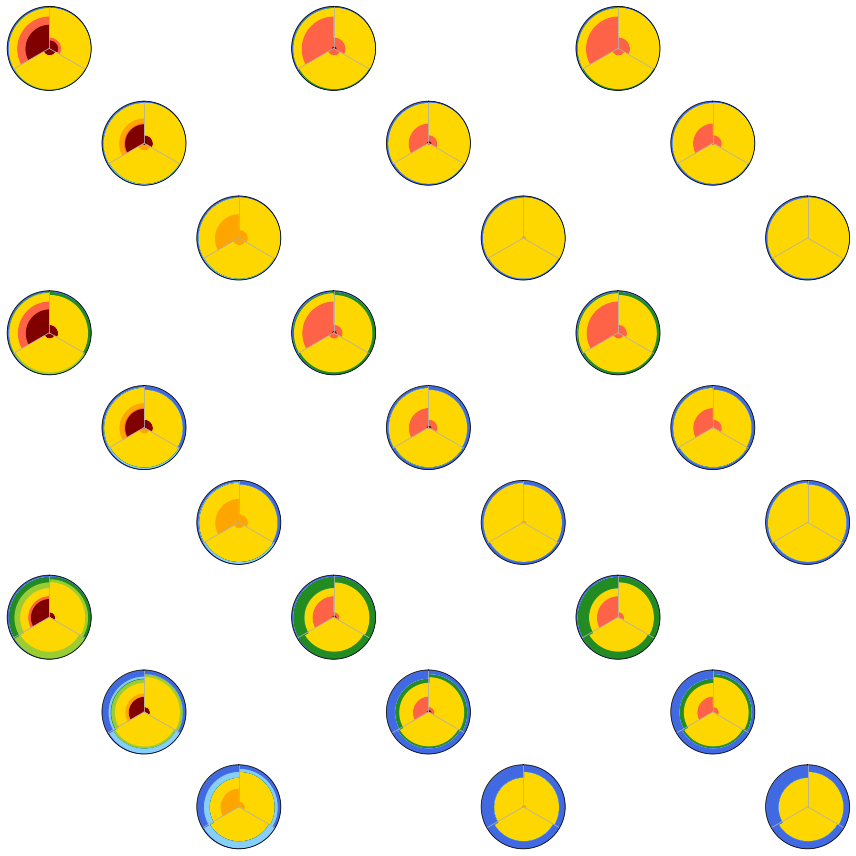

In [10]:
no_users_thresholds = [25, 50, 75]
magnitude_thresholds = [5, 10, 20]
delivery_thresholds = [2, 1, 0]

gs = (grid_spec.GridSpec(9,9))

# Create array of axis positions
pos_x = [[0, 3, 6], [1, 4, 7], [2, 5, 8], [0, 3, 6], [1, 4, 7], [2, 5, 8], [0, 3, 6], [1, 4, 7], [2, 5, 8]]
pos_y = [0, 1, 2, 3, 4, 5, 6, 7, 8]
positions = []
for z in range(len(pos_y)):
    for w in range(len(pos_x[0])):
        positions.append([pos_y[z], pos_x[z][w]])

fig = plt.figure(figsize=(12,12))

#creating empty list
ax_objs = []
count=0
for i in range(len(delivery_thresholds)):
    for j in range(len(no_users_thresholds)):
        for h in range(len(magnitude_thresholds)):
            ax_objs.append(fig.add_subplot(gs[positions[count][0], positions[count][1]], polar=True))
            
            cum_sum_df = group_classifications(drought_impacts_df, delivery_thresholds[i], 
                                               no_users_thresholds[j], magnitude_thresholds[h])

            # Extrapolate curves between angles
            angles = [y/180*np.pi for x in [np.arange(x, x+125,5) for x in cum_sum_df.angle_start] for y in x]
            segment_length = len(np.arange(0, 0+125,5))

            # for every group extrapolate values and draw
            for k in range(1, cum_sum_df.shape[1]-2):
                previous_values = sum([[cum_sum_df.iloc[i, k-1]]*segment_length for i in range(3)], [])
                values = sum([[cum_sum_df.iloc[i, k]]*segment_length for i in range(3)], [])

                # Plot data
                ax_objs[-1].fill_between(angles, previous_values, values, color=colors[k-1], label=f'Group {k}')

            ax_objs[-1].xaxis.set_tick_params(pad=30)

            ax_objs[-1].set_ylim([0,100])
            ax_objs[-1].set_yticklabels([])
            ax_objs[-1].set_rticks([])
            ax_objs[-1].set_thetagrids([0, 120, 240], [])
            ax_objs[-1].set_theta_zero_location("N")
            
            count+=1
plt.tight_layout()
plt.show()